In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from fastai.tabular import add_datepart

### Loading datasets, feature engineering

In [3]:
print('These are the datasets available: \n', os.listdir('flow data/flow data'))
#Note: the usgs_data.csv is just the table from usgs_san_francisquito.txt

These are the datasets available: 
 ['usgs_san_francisquito.txt', 'usgs_data.csv', 'influent_flow.csv', 'weather.csv']


In [4]:
#Looking at influent_flow.csv table, the table containing our target
flow = pd.read_csv('flow data/flow data/influent_flow.csv')
print('Rows: ', flow.shape[0], '\nColumns: ', flow.shape[1])
print(flow.info())

#Change the date column to a datetime type
flow['Date'] = pd.to_datetime(flow['Date'])

flow.head()

Rows:  34516 
Columns:  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34516 entries, 0 to 34515
Data columns (total 2 columns):
Date        34516 non-null object
INF_FLOW    34516 non-null float64
dtypes: float64(1), object(1)
memory usage: 539.4+ KB
None


,Date,INF_FLOW
0,2013-01-15 00:00:00,9.589273
1,2013-01-15 01:00:00,9.272833
2,2013-01-15 02:00:00,8.861329
3,2013-01-15 03:00:00,9.193454
4,2013-01-15 04:00:00,9.129482


In [5]:
#Looking at weather table
weather = pd.read_csv('flow data/flow data/weather.csv')
print('Rows: ', weather.shape[0], '\nColumns: ', weather.shape[1])
print(weather.info())

#Change the date column to a datetime type
weather['Date'] = pd.to_datetime(weather['Date'])

weather.head()

Rows:  44784 
Columns:  8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44784 entries, 0 to 44783
Data columns (total 8 columns):
Date               44784 non-null object
rain               44784 non-null float64
snow               44784 non-null float64
accum              44784 non-null float64
temp               44784 non-null float64
humidity           44784 non-null float64
cloud              44784 non-null float64
app_temperature    44784 non-null float64
dtypes: float64(7), object(1)
memory usage: 2.7+ MB
None


,Date,rain,snow,accum,temp,humidity,cloud,app_temperature
0,2012-12-15 08:00:00,0.0,0.0,0.0,5.95,0.89,0.08,5.95
1,2012-12-15 09:00:00,0.0,0.0,0.0,5.66,0.92,0.09,5.66
2,2012-12-15 10:00:00,0.0,0.0,0.0,5.46,0.91,0.09,5.46
3,2012-12-15 11:00:00,0.0,0.0,0.0,4.82,0.92,0.06,4.82
4,2012-12-15 12:00:00,0.0,0.0,0.0,4.61,0.93,0.03,4.61


In [6]:
#Looking at usgs_san_francisuito.txt table
usgs = pd.read_csv('flow data/flow data/usgs_data.csv', sep = '\t', low_memory = False)
print('Rows: ', usgs.shape[0], '\nColumns: ',usgs.shape[1])
print(usgs.info()) #Looks like we have some missing values in the last 4 columns

#get rid of row 0 (indicating datatype and length for each column)
usgs.drop(0, inplace= True)

#Change the date column to a datetime for this table as well
usgs['datetime'] = pd.to_datetime(usgs['datetime'])

#The original usgs text file indicates the 14747_00060 and 14748_0065 columns 
#indicate discharge and gage height. Lets change the name of those columns
#and their corresponding qualification codes. Let's also rename the 'datetime'
#to 'Date' to be consitent with the other tables

usgs.rename(columns = {'14747_00060': 'discharge', 
            '14747_00060_cd': 'discharge_cd',
            '14748_00065' : 'gage_height',
            '14748_00065_cd' : 'gage_height_cd',
            'datetime' : 'Date'},
           inplace = True)

usgs.head()

Rows:  178896 
Columns:  8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178896 entries, 0 to 178895
Data columns (total 8 columns):
agency_cd         178896 non-null object
site_no           178896 non-null object
datetime          178896 non-null object
tz_cd             178896 non-null object
14747_00060       178676 non-null object
14747_00060_cd    178676 non-null object
14748_00065       178761 non-null object
14748_00065_cd    178761 non-null object
dtypes: object(8)
memory usage: 10.9+ MB
None


,agency_cd,site_no,Date,tz_cd,discharge,discharge_cd,gage_height,gage_height_cd
1,USGS,11164500,2013-01-01 00:00:00,PST,44.1,A,1.27,A
2,USGS,11164500,2013-01-01 00:15:00,PST,44.1,A,1.27,A
3,USGS,11164500,2013-01-01 00:30:00,PST,44.1,A,1.27,A
4,USGS,11164500,2013-01-01 00:45:00,PST,43.2,A,1.26,A
5,USGS,11164500,2013-01-01 01:00:00,PST,43.2,A,1.26,A


In [7]:
# Was just curious to see how much non-publication-reviewed data there is
print(usgs.discharge_cd.unique(), usgs.gage_height_cd.unique())
print(usgs[(usgs['discharge_cd'] !='A') | (usgs['gage_height_cd'] != 'A')].shape)

['A' nan 'P:e' 'A:e' 'P'] ['A' nan 'P']
(12567, 8)


Now that the 3 dataframes have been cleaned up a bit lets merge them together by date

In [8]:
df = flow.merge(weather)
df = df.merge(usgs)
df.set_index('Date', inplace = True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34324 entries, 2013-01-15 00:00:00 to 2016-12-22 14:00:00
Data columns (total 15 columns):
INF_FLOW           34324 non-null float64
rain               34324 non-null float64
snow               34324 non-null float64
accum              34324 non-null float64
temp               34324 non-null float64
humidity           34324 non-null float64
cloud              34324 non-null float64
app_temperature    34324 non-null float64
agency_cd          34324 non-null object
site_no            34324 non-null object
tz_cd              34324 non-null object
discharge          34269 non-null object
discharge_cd       34269 non-null object
gage_height        34323 non-null object
gage_height_cd     34323 non-null object
dtypes: float64(8), object(7)
memory usage: 4.2+ MB
None


In [9]:
# Since we have a relatively small amount of null values I'll assume it's okay to drop 
# those rows for now rather than try to impute their values. Even if there's an MAR or
# MNAR effect happening, the data with missing values likely wont have a meaningful impact 
# on the results given these rows consist of <0.2% of the data. This decision is subject to 
# change with more knowledege about the data

df.dropna(inplace = True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34268 entries, 2013-01-15 00:00:00 to 2016-12-22 14:00:00
Data columns (total 15 columns):
INF_FLOW           34268 non-null float64
rain               34268 non-null float64
snow               34268 non-null float64
accum              34268 non-null float64
temp               34268 non-null float64
humidity           34268 non-null float64
cloud              34268 non-null float64
app_temperature    34268 non-null float64
agency_cd          34268 non-null object
site_no            34268 non-null object
tz_cd              34268 non-null object
discharge          34268 non-null object
discharge_cd       34268 non-null object
gage_height        34268 non-null object
gage_height_cd     34268 non-null object
dtypes: float64(8), object(7)
memory usage: 4.2+ MB
None


In [10]:
#Interestingly, after dropping null values removes all rows without approved discharge
#and gage data

print(usgs.discharge_cd.unique(), usgs.gage_height_cd.unique())

['A' nan 'P:e' 'A:e' 'P'] ['A' nan 'P']


In [11]:
#Check for rows with only one value. They won't have an effect and are simply taking up space
unique_value_cols = [col for col in df.columns if df[col].unique().size == 1]
unique_value = [df[col].unique()[0] for col in df.columns if df[col].unique().size == 1]
print('Column name: \t' ,unique_value_cols,'\nUnique Value\t', unique_value)

Column name: 	 ['snow', 'accum', 'agency_cd', 'site_no', 'discharge_cd', 'gage_height_cd'] 
Unique Value	 [0.0, 0.0, 'USGS', '11164500', 'A', 'A']


In [12]:
#Drop those rows
df.drop(unique_value_cols, axis = 1, inplace = True)
df.head()

,INF_FLOW,rain,temp,humidity,cloud,app_temperature,tz_cd,discharge,gage_height
Date,,,,,,,,,
2013-01-15 00:00:00,9.589273,0.0,10.19,0.26,0.04,10.19,PST,17.1,0.86
2013-01-15 01:00:00,9.272833,0.0,9.76,0.31,0.18,9.76,PST,17.1,0.86
2013-01-15 02:00:00,8.861329,0.0,7.80,0.36,0.07,6.92,PST,17.1,0.86
2013-01-15 03:00:00,9.193454,0.0,6.52,0.43,0.03,6.52,PST,17.1,0.86
2013-01-15 04:00:00,9.129482,0.0,5.69,0.48,0.03,5.69,PST,16.7,0.85


In [13]:
# Here I took notice of the tz_cd had 2 values, because of daylight savings. Just to be 
#thorough, we'll take care of this by converting to GMT time

df.loc['2013-03-10 00:00:00':'2013-03-10 05:00:00'] #<- to show DST occuring

,INF_FLOW,rain,temp,humidity,cloud,app_temperature,tz_cd,discharge,gage_height
Date,,,,,,,,,
2013-03-10 00:00:00,9.423984,0.0,16.93,0.50,0.04,16.93,PST,6.06,0.59
2013-03-10 01:00:00,9.097989,0.0,17.06,0.52,0.03,17.06,PST,6.06,0.59
2013-03-10 03:00:00,8.230157,0.0,13.42,0.71,0.04,13.42,PDT,5.80,0.58
2013-03-10 04:00:00,7.811428,0.0,11.70,0.72,0.00,11.70,PDT,5.80,0.58
2013-03-10 05:00:00,7.814624,0.0,10.78,0.75,0.00,10.78,PDT,5.80,0.58


In [14]:
#Drop the timezone column
df.drop('tz_cd', axis = 1, inplace = True)

In [15]:
#Preserve local dattime in new column incase it's needed later.
df['Date_local'] =  df.index

In [16]:
#Convert the datetime index to GMT. Can be changed later
dti = pd.date_range(start = '2013-01-15', freq = 'H', periods = df.shape[0], tz = 'GMT')
df.index = dti
df.index.name = 'Date_GMT'
df.loc['2013-03-10 00:00:00':'2013-03-10 05:00:00']

,INF_FLOW,rain,temp,humidity,cloud,app_temperature,discharge,gage_height,Date_local
Date_GMT,,,,,,,,,
2013-03-10 00:00:00+00:00,9.423984,0.0,16.93,0.50,0.04,16.93,6.06,0.59,2013-03-10 00:00:00
2013-03-10 01:00:00+00:00,9.097989,0.0,17.06,0.52,0.03,17.06,6.06,0.59,2013-03-10 01:00:00
2013-03-10 02:00:00+00:00,8.230157,0.0,13.42,0.71,0.04,13.42,5.80,0.58,2013-03-10 03:00:00
2013-03-10 03:00:00+00:00,7.811428,0.0,11.70,0.72,0.00,11.70,5.80,0.58,2013-03-10 04:00:00
2013-03-10 04:00:00+00:00,7.814624,0.0,10.78,0.75,0.00,10.78,5.80,0.58,2013-03-10 05:00:00
2013-03-10 05:00:00+00:00,7.510198,0.0,10.69,0.78,0.07,10.69,5.80,0.58,2013-03-10 06:00:00


In [17]:
#Create features for each component of the time series.

# The prompt mentions the plant doesn't control the amount of flow coming in. This likely means
# the flow is mostly caused by natural cycles. Considering this, datetime units indicating natural 
# cycles (i.e hour of day, time of year) are probably more important. We can try
# all to be thorough and remove them later if they add no predictive power to our model for
# better interpretability for the client

df['dt_hour_of_day'] = pd.DatetimeIndex(df.index).hour
df['dt_'] = df.index
df = add_datepart(df, 'dt_', drop = True) #This will add most calendar date features

In [18]:
df.columns

Index(['INF_FLOW', 'rain', 'temp', 'humidity', 'cloud', 'app_temperature',
       'discharge', 'gage_height', 'Date_local', 'dt_hour_of_day', 'dt_Year',
       'dt_Month', 'dt_Week', 'dt_Day', 'dt_Dayofweek', 'dt_Dayofyear',
       'dt_Is_month_end', 'dt_Is_month_start', 'dt_Is_quarter_end',
       'dt_Is_quarter_start', 'dt_Is_year_end', 'dt_Is_year_start',
       'dt_Elapsed'],
      dtype='object')

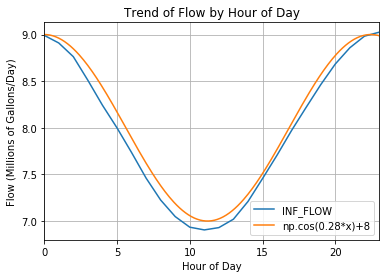

In [19]:
#This is interesting. Flow has an almost perfect cosine shaped trend over the course of an average day

hourly_flow_trend = df.groupby(['dt_hour_of_day'])['INF_FLOW'].mean()
x = np.arange(0,7.6*np.pi,0.1)
y = np.cos(0.28*x)+8
cosine_data = pd.DataFrame([y,x])
hourly_flow_trend.plot(grid = True)
plt.plot(x,y)
plt.xlabel('Hour of Day')
plt.title('Trend of Flow by Hour of Day')
plt.ylabel('Flow (Millions of Gallons/Day)')
plt.legend(labels = ['INF_FLOW', 'np.cos(0.28*x)+8'])

### Model

I decided to use a Random Forest for a few reasons:
   1. Great at handling mixed data types
   2. Highly interpretable. The intuition behind decision trees/random forests is easy to understand (even more 
       than linear regression or especially something like a neural network)
   3. The .feature_importances() attribute makes it almost trivial to determine strongest predictors. The 
       magnitude of model cofficients in linear regression don't necessarily determine strength of prediciton.
       
Due to time constraints, I used Random Search Cross Validation rather than Grid Search. Given more time, I could use the latter for the absolute best results.

In [20]:
#Import sklearn model libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pickle

In [21]:
data = df.drop('Date_local', axis = 1)

# Create target and features
y = data['INF_FLOW']
model_features = list(data.columns.tolist()[1:])
X = data[model_features]

In [22]:
#Create our training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [45]:
#parameter grid for random search
random_grid = {'n_estimators' : [100,250,1000],
       'max_depth' : [10, 50, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_leaf' : [1, 2 ,4],
       'min_samples_split' : [2, 5, 10]}

#base model
rfr = RandomForestRegressor(n_estimators = 10)

#Random search
rfr_random_search = RandomizedSearchCV(estimator = rfr, 
                                       param_distributions = random_grid,
                                      n_iter = 5,
                                      cv = 5,
                                      random_state = 17,
                                      n_jobs = -1,
                                      verbose = 2)

In [46]:
rfr_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  2.1min remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=None,

In [47]:
#save the random search
pickle.dump(rfr_random_search, open('rf_random_search.sav', 'wb'))

In [50]:
#load the random search
random_forest_search = pickle.load(open('rf_random_search.sav', 'rb'))

In [51]:
#Show best 5 models
results_ranked = pd.DataFrame(random_forest_search.cv_results_).sort_values(by = 'rank_test_score')
results_ranked[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,26.470835,0.459201,0.175810,0.002597,100,5,2,auto,50,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.847033,0.845639,0.848147,0.877254,0.852521,0.854119,0.011795,1
0,55.713617,0.614871,0.350359,0.003395,250,5,4,auto,100,"{'n_estimators': 250, 'min_samples_split': 5, ...",0.836284,0.834918,0.837935,0.863523,0.844119,0.843356,0.010563,2
1,21.799653,1.326651,0.142598,0.012324,100,5,4,auto,50,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.836053,0.833430,0.836228,0.862685,0.843593,0.842398,0.010694,3
4,40.447560,4.472388,0.864516,0.114027,1000,2,4,sqrt,100,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.835331,0.820277,0.827538,0.847554,0.827429,0.831626,0.009280,4
3,38.002284,0.149632,0.180834,0.006152,250,10,2,auto,10,"{'n_estimators': 250, 'min_samples_split': 10,...",0.814947,0.810948,0.813140,0.843481,0.816980,0.819899,0.011958,5


In [52]:
random_forest_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50}

In [53]:
rf = RandomForestRegressor(n_estimators = 100,
                            min_samples_split = 5, 
                            min_samples_leaf = 2, 
                            max_features = 'auto',
                            max_depth = 50,
                            bootstrap = True,
                            n_jobs = -1,
                            oob_score = True)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [56]:
print('R^2 train data score: ', rf.score(X_train, y_train))
print('R^2 test data score: ', rf.score(X_test, y_test))
print('OOB score: ', rf.oob_score_)

R^2 train data score:  0.9626483076074585
R^2 test data score:  0.8583628737687243
OOB score:  0.8639309911027211


In [58]:
#The model is slightly overfit but performs fairly well. Could be fixed with more hyperparameter tuning and
#handling of time-series data

rf.feature_importances_

array([5.713490e-02, 1.643925e-02, 7.163224e-02, 1.204418e-02, 1.751316e-02, 1.180919e-01, 4.490443e-01, 9.791255e-02,
       3.192670e-03, 2.391168e-03, 8.177740e-03, 2.607787e-02, 1.356047e-02, 1.789838e-02, 9.871068e-04, 4.980507e-04,
       1.605920e-04, 9.471827e-04, 8.241907e-05, 4.938582e-04, 8.571999e-02])

In [149]:
sorted_feature_importances = sorted(zip(map(lambda x: round(x,4), rf.feature_importances_), X.columns), reverse = True)
df_feature_importances = pd.DataFrame(sorted_feature_importances, columns = ['Feature Importance','Feature Name'])
df_feature_importances.set_index('Feature Name')

,Feature Importance
Feature Name,
gage_height,0.4490
discharge,0.1181
dt_hour_of_day,0.0979
dt_Elapsed,0.0857
humidity,0.0716
rain,0.0571
dt_Day,0.0261
dt_Dayofyear,0.0179
app_temperature,0.0175


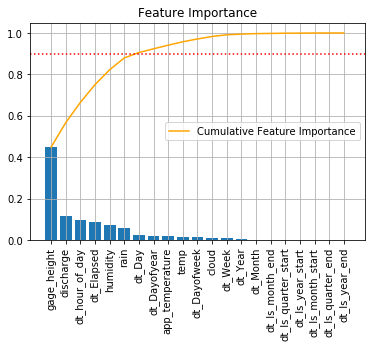

In [191]:
importances = rf.feature_importances_
importances[::-1].sort()
indices = np.argsort(importances)[::-1]
cum_var = [importances[:x+1].sum() for x in range(len(importances))]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.plot(cum_var, c = 'orange')
plt.axhline(0.9, c = 'red', linestyle = 'dotted')
plt.grid()
plt.legend(labels = ['Cumulative Feature Importance'], loc = 'center right')
plt.show()

In [194]:
reduced_feature_columns = ['gage_height', 'discharge', 'dt_hour_of_day', 'dt_Elapsed', 'humidity', 'rain']
X_reduced_columns = df[reduced_feature_columns]

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_columns, y)

In [198]:
rf_reduced_features = RandomForestRegressor(n_estimators = 100,
                            min_samples_split = 5, 
                            min_samples_leaf = 2, 
                            max_features = 'auto',
                            max_depth = 50,
                            bootstrap = True,
                            n_jobs = -1,
                            oob_score = True)
rf_reduced_features.fit(X_train, y_train)
print('R^2 train data score: ', rf_reduced_features.score(X_train, y_train))
print('R^2 test data score: ', rf_reduced_features.score(X_test, y_test))
print('OOB score: ', rf_reduced_features.oob_score_)

R^2 train data score:  0.9514183724338984
R^2 test data score:  0.8581013903259658
OOB score:  0.8414928884549722
